In [2]:
!pip install jupyter ipywidgets
!pip install pydotplus
!pip install shap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import shap
import tempfile

from IPython.core.display import display, HTML
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

The ```choose_rand_interval``` function choose a 100 sized random interval  of samples from test set.

The ```plot_heatmap_randSample``` function comuputes the SHAP values on a chosen random interval on the test set and plot the heatmap.

In [3]:
# let's choose a random interval
import random 

def choose_rand_interval(seed, sample):
    random.seed(seed)
    a = random.randint(0, sample.shape[0])
    b = a + 100
    return (a, b)


def plot_heatmap_randSample(seed, sample, clf):
    # compute shap_values using a random interval on the test_set
    interval = choose_rand_interval(seed, sample)
    kernel_explainer = shap.KernelExplainer(clf.predict, sample[interval[0]: interval[1]])
    shap_values = kernel_explainer.shap_values(sample[ interval[0]: interval[1]])

    print(interval[0], interval[1])

    # plotting heatmap
    shap.plots.heatmap(
        shap.Explanation(
                values=shap_values[:100],
                feature_names=sample.columns.tolist()
            )
        )

In [4]:
def get_randInstance(seed, sample):
    random.seed(seed)
    return random.randint(0, sample.shape[0])

In [5]:
def simple_SHAP(df_shap, df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable', how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

## Brief recall on models used on classification 📊

During the classification task, we have trained essentially 5 models:
- K-Nearest Neighbors (KNN)
- Naive Bayes (NB)
- Support Vector Machine (SVM)
- Random Forest (RF)
- Decision Tree (DT)

on two versions of the mushrooms dataset:

- the ```original dataset```: the original one, 
- the ```reduced dataset```: have been removed all the features that **might be hard/impossible to see or to determine** such as the odor, the root of the stalk, the color of the spores, the population, and the habitat.



## What we are going to analyze 👨‍💻 🔍

We decide to make an analysis of explainability only for the models:
- **K-Nearest Neighbors (KNN)** as a **black-box model**
- **Decision Tree** as a **white-box model**

on the **original dataset** with reduced dimensionality perfomed by **Recursive Feature Elimination** during the training phase in the classification.

We chose:
- **K-Nearest Neighbors** because it was the best in terms of performance on recall on poisonous class, so there were very few false edible on test; 
- **Decision Tree** since it achieves a very good perfomances on recall score on poisonous class, and beacuse it is simple to explain by showing its structure, that easily describes the rules it is composed of.

## Explanation of KNN

In this section, we are going to analyze the explainablity of KNN model with SHAP.
In particular, using SHAP we perfomed two kind of analysis:
- **global interpretability**: the collective SHAP values can show how much each feature contributes, either positively or negatively, to the target variable.
- **local interpretability**: interpret the prediction of the model on specific records that are correctly/incorrectly classified.


### Best KNN model

In [6]:
knn_features = [
    'edible',
    'bruises',
    'odor_f',
    'odor_n', 
    'odor_p',
    'stalk-color-below-ring_y',
    'spore-print-color_r'
]

Let's read the mushrooms one-hot encoded dataset to make an analysis of explainability. We will consider the dataset with only the relevant features obtained from RFE.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
mushrooms_ohe = pd.read_csv('/content/drive/MyDrive/BDA/explanation/mushrooms_ohe.csv')
mushrooms_ohe = mushrooms_ohe[knn_features]
label = mushrooms_ohe.pop('edible')

Let's split the dataset into train and test.

In [9]:
train_set, test_set, train_label, test_label = \
    train_test_split(
        mushrooms_ohe, label, stratify=label, test_size=0.3, random_state=42
    )

Let's train the model with its best configuration from classification notebook.

In [10]:
best_knn_params = {
    'algorithm': 'auto',
    'metric': 'jaccard',
    'n_neighbors': 23
}

knn = KNeighborsClassifier(**best_knn_params).fit(train_set, train_label)

### Using SHAP Kernel Explainer

Since **K-Nearest Neighbors is a ML non-tree-based model**, it may be explainaed using **KernelExplainer with SHAP**.

We decided to perfom the analys on 300 samples for time reason.

In [11]:
kernel_explainer = shap.KernelExplainer(knn.predict, test_set[:300])
#knn_shap_values = kernel_explainer.shap_values(test_set[:300])
#np.savetxt('knn_shap_values.txt', knn_shap_values)
knn_shap_values = np.loadtxt('/content/drive/MyDrive/BDA/explanation/knn_shap_values.txt')

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


First let's focus on **Global Interpretability**

### Variable Importance Plot for Global Interpretability

The ```shap.summary_plot``` function with plot_type="bar" produces the variable importance plot.

This  plot lists the **most significant features in descending order** with their corresponding **mean absolute SHAP values**. The top variables contribute more to the model than the bottom ones and thus have high predictive power.

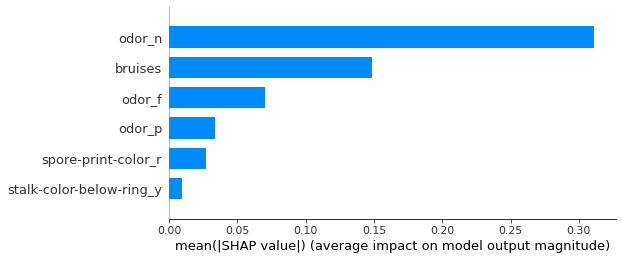

In [12]:
shap.summary_plot(knn_shap_values, test_set, plot_type='bar')

As we can see from the above plot, the high predictive power variable is **odor = None**, followed by the **presence of bruises** and **odor_f = foul**

To **analyze the relationship** of the **most significant features** and the **target value**, we produced the following plot:

This plot is made by the records in the test data and it shows **positive** and **negative relationship** among the **relevant features** and the **edibililty target**. 

The **colors** shows whether the **impact** of the **feature** is **positive** (red) or **negative** (blue). Here we have **only boolean values** so we have only two colors.

Like before, the features are ranked in descending order and the **maginitude of impact** of each feature can be inferred by looking at the **horizontal location**: the longer are the bars, the higher is the predictive power (SHAP value).

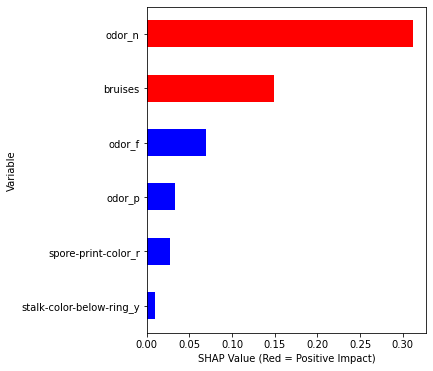

In [13]:
simple_SHAP(knn_shap_values, test_set[:300])

We can say that **the absence of odor** has an **high and positive impact on the edibility prediction**. The **high** comes from the high SHAP value, and the **positive** impact is indicated by the red color. The **same** holds for **bruises**.

In contrast, **foul odor** is **lower** in predictive power and **negatively correlated with the edibility** (see blue color).

### SHAP Dependence Plot for Global Interpretability

The **partial dependence plot** shows the marginal effect one or two features have on the prediction of the model.

It tells whether the **relationship between the target and a feature** is **linear**, **monotonic** or **more complex**.

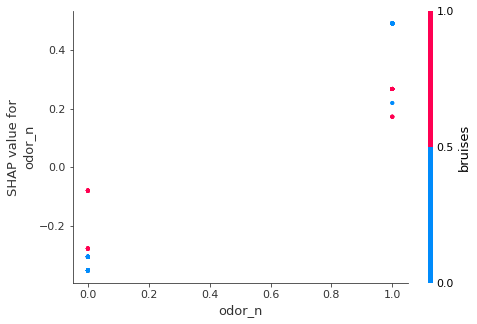

In [14]:
shap.dependence_plot("odor_n", knn_shap_values, test_set[:300])

The following plot shows there is a **linear and positive trend** between **odor_n** and the **edibilty**, and **odor_n** interacts with bruises.

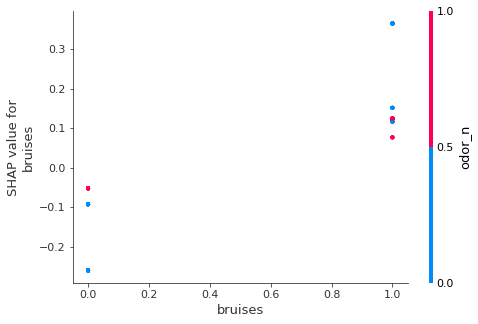

In [15]:
shap.dependence_plot("bruises", knn_shap_values, test_set[:300])

The following plot shows there is a **approximately linear and very weak positive trend** between **bruises** and the **edibilty**, and **bruises** interacts with odor_n.

### Heatmap plot

In the following blocks, we are going to analyze the heatmap plots that are used to visualize the magnitude of data in two dimensions.

The ```heatmap plot``` function takes in input a matrix of SHAP values and creates a plot with the instances on the X-axis, the relevant features in the Y-axis, and the SHAP values encoded on a color scale.
By default the samples are ordered using ```shap.order.hclust```, which orders the samples based on a hierarchical clustering by their explanation similarity. 

The heatmap plot also shows  the f(x) curve (on the top) that is the model predictions for the instances. 

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with fe

2247 2347


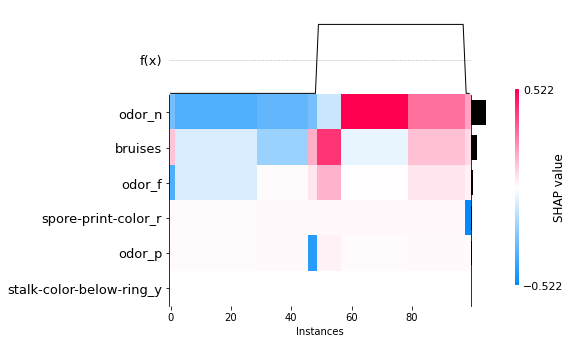

In [16]:
plot_heatmap_randSample(35, test_set, knn)

As we can see this plot show how edibility is mostly affected by the top 3 relevant features:

- Instances [0, 40]: odor_none, bruises and odor_foul have negative impact, then f(x) goes to 0.
- Instances [50, 60]: odor_none has a medium negative impact, bruises have a high positive impact and odor_foul have medium positive impact, then f(x) goes to 1.

- Instances [60, 90]: odor_none has a medium/high positive impact, bruises and odor_foul have for the first half low/medium negative impact and low/medium positive impact, then f(x) goes to 1.

When all of them have low positive impact and spore_print_color_r has very high negative impact, then f(x) goes to 0.


In the following block, we repeat the analys on a differt range.

In [ ]:
plot_heatmap_randSample(55, test_set, knn)

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with fe

As we can see this plot show how edibility is mostly affected by the top 3 features:

- Instances [0, 50]: odor_none high/medium positive impact, bruises and odor_foul first have low/nill negative impact and then low positive impact , then f(x) goes to 1.
- Instances [50, 55]: odor_none has a high negative impact, bruises and odor have medium positive impact, then f(x) goes to 0.
- Instances [55, 75]: odor_none has a medium negative impact, bruises have a high positive impact and odor_foul have medium positive impact, then f(x) goes to 1.

In the rest of the instances 2/3 of the top 3 relevant features have medium/high negative impact, then f(x) tends to 0.


### Individual SHAP Value Plot for Local Interpretability

Let's randomly choose a few observations for local explanability:

### Local explainers single records

The function shap.force_plot() takes in input:
- the **base value**: that is the average of the prediction over the test set

#### Explanability on correctly classified records ✅

Let's locally explain the prediction of 3 samples that are correctly classified using ```shap.force_plot```

In [ ]:
shap.initjs()
shap.force_plot(kernel_explainer.expected_value, knn_shap_values[45], test_set.iloc[45])

In this first record we see that all the features make the base value to increase, up to the final classification of "1" (*edible*) and the odor_none, bruises and odor_foul contribute the most.

In [ ]:
shap.initjs()
shap.force_plot(kernel_explainer.expected_value, knn_shap_values[60], test_set.iloc[60])

In this second record we see the feature that contribute the most, to make the base value to increase up to 1 (**edibile**), is **odor_none** and only bruises negativly impat on the prediction.

In [ ]:
shap.initjs()
shap.force_plot(kernel_explainer.expected_value, knn_shap_values[70], test_set.iloc[70])

In this third record we see that the top 2 relevant features, odor_none and bruises, make the base value to decrease up to the final classification of 0 (**poisonous**) despite the others make the base value increase.

### TREPAN on KNN

**TREPAN** is a global explainer that can be used to explain any type of black box, in our case **KNN**.

The goal is to map:  **KNN --> DT** classifier using best-m-of-n rules.

In [ ]:
y_pred_train = knn.predict(train_set)

It **learns** to **predict** the **label** returned by the **KNN**, not the original one in the dataset.

In [ ]:
explainer = DecisionTreeClassifier(max_depth=8).fit(train_set, y_pred_train)

The accuracy in this case is also called **"fidelity"** and indicates how much the **DT** is aderent with the **KNN**.

In [ ]:
attribs = [feature for feature in knn_features if feature != 'edible']

dot_data = tree.export_graphviz(explainer, out_file=None, 
                                feature_names=attribs, 
                                #class_names=explainer.classes_,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

In [ ]:
# getting fidelity measure of the tree obtained from KNN
y_pred = knn.predict(test_set)
accuracy_score(y_pred, explainer.predict(test_set))

We have a fidelity of 100%, so a decision tree with a max depth of 8 levels is able to perfectly mimic the KNN model.

### Explanability on misclassified records ❌

Let's locally explain the prediction of 3 samples that are misclassified using ```decision plot```

In [ ]:
in_attribs= [feature for feature in knn_features if feature != 'edible']
mushrooms_ohe['edible'] = label
mushrooms_ohe['prediction'] = knn.predict( mushrooms_ohe[in_attribs].values )
mushrooms_ohe['edible']= mushrooms_ohe['edible'].astype('bool')

In [ ]:
misclassified_df= mushrooms_ohe.loc[ (~mushrooms_ohe['edible'] == mushrooms_ohe['prediction'] )  ,  ]
misclassified_df['edible'] = misclassified_df['edible'].astype('int64')
print( misclassified_df.head() )

misclassified_set = misclassified_df.drop(columns= ['edible', 'prediction'])

In [ ]:
expected_value = kernel_explainer.expected_value
print("The base value is", expected_value)
shap_values = kernel_explainer.shap_values(misclassified_set.iloc[get_randInstance(123, misclassified_set),:])
shap.decision_plot(expected_value, shap_values, misclassified_set.iloc[get_randInstance(123, misclassified_set),:])
print(get_randInstance(123, misclassified_set))

In [ ]:
expected_value = kernel_explainer.expected_value
print("The base value is", expected_value)
shap_values = kernel_explainer.shap_values(misclassified_set.iloc[get_randInstance(12, misclassified_set),:])
shap.decision_plot(expected_value, shap_values, misclassified_set.iloc[get_randInstance(12, misclassified_set),:])
print(get_randInstance(12, misclassified_set))

In [ ]:
expected_value = kernel_explainer.expected_value
print("The base value is", expected_value)
shap_values = kernel_explainer.shap_values(misclassified_set.iloc[get_randInstance(321, misclassified_set),:])
shap.decision_plot(expected_value, shap_values, misclassified_set.iloc[get_randInstance(321, misclassified_set),:])
print(get_randInstance(321, misclassified_set))

As we can see here from these plots, the fact that a mushrooms hasn't any odor leads the model to misclassify these few records. 

For all the 24 misclassified instances hold:
- **odor_none** = 1
- **spore_print_color_r** = 0
- **stalk-below-ring_yellow** = 0

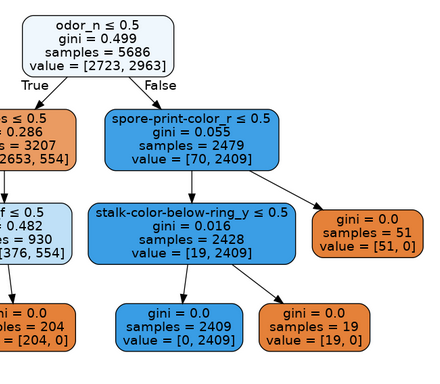

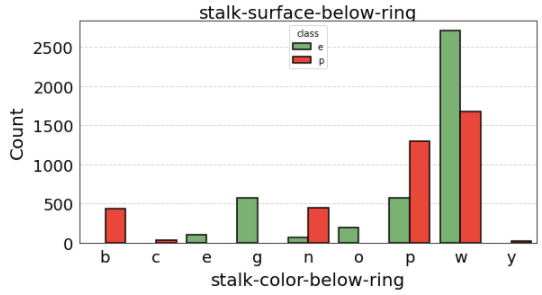

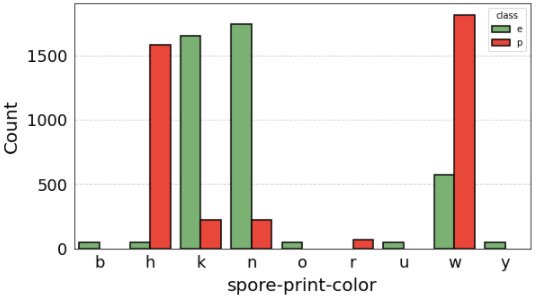

But, if we give a look to the Decision tree obtained by Trepan, the erroneous decision is based on the fact that the stalk below the ring is yellow or not, which is the least important feature for this model, and, moreover, there are more more other color for the stalk below the ring. 

This is the reason why the model misclassifies these instances, in fact, we can see that all these misclassified mushrooms have 1 on the feature 'odor_n' and have 0 on the feature 'spore-print-color_r', so all the decision is based on the feature 'stalk-color-below-ring_y'.

## Explanation of Decision Tree

In this section, we are going to analyze the explainablity of DT model with and without SHAP.

The features below (plus 'edible') are the ones identified by the RFE in the classification task.

In [ ]:
dt_features = [
    'edible',
	'bruises', # yes/no blue spot
	'odor_n', # no odor
	'odor_p', # pungent
	'spore-print-color_h', # chocolate
	'spore-print-color_r', # green
	'habitat_u' #urban
]

mushrooms_ohe = pd.read_csv('/content/drive/MyDrive/BDA/explanation/mushrooms_ohe.csv')
mushrooms_ohe = mushrooms_ohe[dt_features]
label = mushrooms_ohe.pop('edible')

Let's split the dataset into train and test.

In [ ]:
train_set, test_set, train_label, test_label = \
    train_test_split(
        mushrooms_ohe, label, stratify=label, test_size=0.3, random_state=42
    )

### Best DT model

Let's train the model with its best configuration from classification notebook.

In [ ]:
best_dt_params = {
    'max_depth': 8
}

in_attribs = [
    feature for feature in mushrooms_ohe.columns
    if feature in dt_features and feature != 'edible'
]

dt = DecisionTreeClassifier(**best_dt_params).fit(train_set, train_label)

### Feature Importance for Global Interpretability

The **DT** computes the importance of a feature as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

In [ ]:
for importance, feature in zip(dt.feature_importances_, in_attribs):
  print(round(importance, 2), feature)

### Feature Importance Plot for Global Interpretability using SHAP 

Since **DT is a tree-based model**, it may be explained using **TreeExplainer with SHAP**.

In [ ]:
dt_shap_values = shap.TreeExplainer(dt).shap_values(test_set)
shap.summary_plot(dt_shap_values, test_set, plot_type="bar", class_inds=[1])
simple_SHAP(dt_shap_values[1], test_set)

In the bar plot above we see the mean absolute shap value for each feature, from the most important (odor_n) to the least one (habitat_u). The red color of the 

As for the SHAP values for the KNN, the first two most important features are 'odor_n' and 'bruises', but the third one is 'odor_p' and not 'odor_f' because the latter is not present in the RFE features.

### Plot decision tree for Local Explanability

Let's show the Decsion Tree's structure to describe the rules it is composed of for local explanability 

In [ ]:
dot_data = tree.export_graphviz(dt, out_file=None,
                                feature_names=in_attribs,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

Here we can see the rules followed by decision tree to make predictions. 

The orange/red nodes represent samples classified as poisonous, and the blue nodes represent instances classified as edible. 

As we can see, in the left subtree all the samples are correctly classified either as edible or poisonous, while in the right subtree, 37 records are misclassfied. In particular, these records are **true poisonous classified as edible**.

#### Most correct relevant rule:

- **any odor, no bruises** => 2277 poisonous mushrooms

#### Dangerous rules that produces false edible:

- **no odor, spore_print_color_r ≠ green, bruises** => 1339 edible but also **7 false edible** 
 
- **no odor, spore_print_color_r/h ≠ green/chocolate, no bruises, habitat ≠ urban**  => 950 edible but also **30 false edible** 

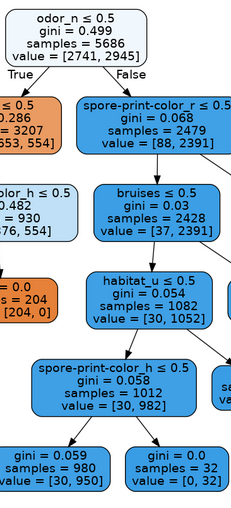

In [ ]:
jovian.commit()